# Example: Image segmentation using customized UNET 3+ and hybrid loss

In [16]:
import numpy as np
from glob import glob
import tensorflow as tf

In [17]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

This example requires `keras-unet-collection==0.1.6` or higher:
```
pip install keras-unet-collection
```

In [18]:
from swiss_army_keras import models, base, utils

In [19]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/home/matteo/Documents/oxford_iiit/'

## The Oxford-IIIT Pets dataset

This example applies the dataset of [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al. 2012). This dataset contains images of pets and their pixel-wise mask that indicates (1) pixels belonging to the pet, (2) pixels bordering the pet, and (3) surrounding pixels.

The Oxford-IIIT Pets dataset will be downloaded and unpacked through the cell blow.

In [20]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)

In [21]:
import tensorflow_hub as hub

In [22]:
#extractor = hub.KerasLayer('https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2', input_shape=(513, 513, 3), signature='image_feature_vector', signature_outputs_as_dict=True, trainable=False)


In [23]:
#m = extractor(Input((513,513,3)))

In [24]:
#l = m['reduction_1/expansion_output']

## Customizing a segmentation model based on UNET 3+

In this example, an image segmentation model is proposed to classify the pixel mask by taking the re-sized RGB images as inputs.

The architecture of UNET 3+ is applied in this segmentation task. UNET 3+ is a convolutional neural network with encoder-decoder blocks, similar to the conventionally used Unet, and with technical highlights of full-scale skip connections, deep supervision, and classification-guided module (CGM). In Huang et al. (2020), UNET 3+ overperformed Unet and Unet++ in the dataset of ISBI LiTS 2017 Challenge.

We specify five downsampling blocks with the number of convolution filters grows from 32 to 512. Each downsampling level consists of two convolutional layers. The upsampling block of UNET 3+ features a full-scale skip connection of five input tensors, and each tensor is originated from a different down-/upsampling level. Within the upsampling block, each input tensor is processed by a convolutional layer with 32 filters ( `filter_num_skip=32` ), then concatenated, and passed through another convolutional layer with 160 filters ( `filter_num_aggregate=160` ). The resulting tensors are collected and fed into either the next upsampling block or the output section. 

The code cell below configures the base architecture of this segmentation model. The input size is fixed to 128-by-128. Batch normalization is applied after each of the convolutional layers. Down- and upsampling are achieved through maxpooling and bilinear interpolation, respectively.

Further use case of `base.unet_3plus_2d_base` is available through its Python helper function:

```python
from swiss_army_keras import models

help(base.unet_3plus_2d_base)
```

In [25]:
name = 'deeplab_v3_plus'
activation = 'ReLU'
filter_num_down = [32, 64, 128, 256, 512]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 3

# `unet_3plus_2d_base` accepts an input tensor 
# and produces output tensors from different upsampling levels
# ---------------------------------------- #
input_tensor = keras.layers.Input((128, 128, 3))
# base architecture
X_decoder = base.deeplab_v3_plus(
    input_tensor,
    3,
    deep_layer=4,
    atrous_rates=[],
    backbone='hub://EfficientNet-lite0',
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
    batch_norm=True, pool=True, unpool=True, name=name)

EfficientNet-lite0
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [11]:
X_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
EfficientNet-lite0_backbone (Fu [(None, 256, 256, 32 3413024     input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 1, 1, 672)    0           EfficientNet-lite0_backbone[0][3]
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 1, 256)    172288      average_pooling2d[0][0]          
______________________________________________________________________________________________

The collected feature maps as four-dimensional tensors of (sample number, width, height, channel) are shown as follows:

In [12]:
X_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
EfficientNet-lite0_backbone (Fu [(None, 256, 256, 32 3413024     input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 1, 1, 672)    0           EfficientNet-lite0_backbone[0][3]
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 1, 256)    172288      average_pooling2d[0][0]          
______________________________________________________________________________________________

**Deep supervision**

The output section of UNET 3+ consists of deep-supervision and Classification-Guided Module (CGM).

Deep-supervision upsamples intermediate feature maps to full-resolution and enables the back-propagation of training loss from these full-resolution branches. Based on Huang et al. (2020). The deep-supervision branch of UNET 3+ consists of 3-by-3 convolutional layers followed by bilinear-interpolation-based upsampling and sigmoid output activation.

The code cell below constructs deep-supervision branches. Alternatively, `swiss_army_keras.models.unet_3plus_2d` with `deep_supervision=True` would produce the same keras model.

In [13]:
# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices 
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])
    
    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear', 
                     name='{}_output_sup{}'.format(name, i-1))(X)
    
    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

TypeError: 'Functional' object is not subscriptable

The deep-supervision and final output tensors are shown as follows:

In [ ]:
OUT_stack

**Classification-guided Module (CGM)**

Huang et al. (2020) proposed CGM for handling the over-segmentation problem. CGM takes the output tensor of the deepest downsampling level, and converts it into a *single value* that indicates the probability of the existence of the segmentation target.

The code cell below adds CGM into the existing deep-supervision branches.

**Note**

The CGM value is not trained separately in this example. 

In Huang et al. (2020), the CGM is trained with "none-organ images". This is not explicitly available in the Oxford-IIIT dataset.

In [ ]:
# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1) # <----- This value could be trained with "none-organ image"

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        # deep-supervision
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        # final output
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))

In [ ]:
OUT_stack

**Compiling the segmentation model**

The segmentation model is trained with cross-entropy loss. Each deep-supervision branch contributes 12.5% of the total loss value, whereas the final output loss contribution is 50%. The Adam optimizer with a learning rate of 1E-4 is applied.

In [16]:
# executing all the above cells in one time to avoid dupilcated tensor names.
unet3plus = keras.models.Model([input_tensor,], OUT_stack)

**Hybrid loss**

The hybrid loss function, as suggested in Huang et al. (2020) is implemented.

**Note** 

* The MS-SSMI loss is found lack of robustness in training, likely becuase of the hard-labeled binary target.

* The focal loss is replaced by the focal Tversky loss.

In [15]:
from swiss_army_keras import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

In [11]:
sparse_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

This hybrid loss is applied for deep supervisions and the final pridction:

In [13]:
unet3plus.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
                  loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4))

NameError: name 'unet3plus' is not defined

In [12]:
X_decoder.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4))

## Data pre-processing

The input of RGB images are resized to 128-by-128 through the nearest neighbour scheme, and then normalized to the interval of [0, 1]. The training target of pixel-wise masks are resized similarly.

A random split is applied with 80%, 10%, 10% of the samples are assigned for training, validation, and testing, respectively.

In [26]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array#/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

In [27]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 5912:739:739


In [28]:
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))

In [29]:
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))
test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))

In [30]:
valid_target[-1][:,:,0].shape

(128, 128)

## Training

The segmentation model is trained with fixed 10 epoches. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [18]:
N_epoch = 10 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        temp_out = X_decoder.predict([valid_input])
        y_pred = temp_out
        print(temp_out.shape, y_pred.shape, valid_target.shape)
        record = np.mean(sparse_entropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        # train on batch
        loss_ = X_decoder.train_on_batch([train_input,], 
                                         [train_target])
        print(loss_)
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    temp_out = X_decoder.predict([valid_input])
    y_pred = temp_out
    record_temp = np.mean(sparse_entropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

(739, 128, 128, 3) (739, 128, 128, 3) (739, 128, 128, 3)
	Initial loss = 0.9885953664779663
1.1281365156173706
0.998392641544342
0.9224480986595154
0.9399794340133667
0.793685793876648
0.8230295181274414
0.7648475170135498
0.7475354671478271
0.8625696301460266
0.7003337740898132
0.7911456823348999
0.7678935527801514
0.6669487953186035
0.7146708965301514
0.6799893975257874
0.689227283000946
0.7623464465141296
0.7148174047470093
0.6704409718513489
0.6408416032791138
0.7195181250572205
0.6955879330635071


KeyboardInterrupt: 

## Evaluation

The testing set performance is evaluated.

In [19]:
temp_out = X_decoder.predict([test_input,])
y_pred = temp_out[-1]

In [20]:
y_pred = temp_out

In [21]:
print('Testing set cross-entropy loss = {}'.format(np.mean(sparse_entropy(test_target, y_pred))))
#print('Testing set focal Tversky loss = {}'.format(np.mean(losses.focal_tversky(test_target, y_pred))))
#print('Testing set IoU loss = {}'.format(np.mean(losses.iou_seg(test_target, y_pred))))

Testing set cross-entropy loss = 1.0923103094100952


**Example of outputs**

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax

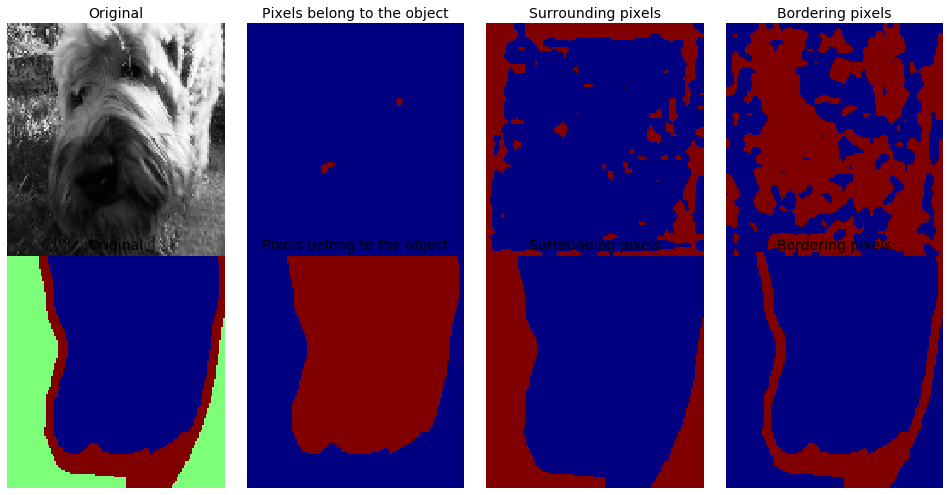

In [24]:
i_sample = 2

fig, AX = plt.subplots(2, 4, figsize=(13, (26-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    for ax2 in ax:
        ax2 = ax_decorate_box(ax2)
AX[0][0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[0][1].pcolormesh(y_pred[i_sample, ..., 0]>0.5, cmap=plt.cm.jet)
AX[0][2].pcolormesh(y_pred[i_sample, ..., 1]>0.5, cmap=plt.cm.jet)
AX[0][3].pcolormesh(y_pred[i_sample, ..., 2]>0.5, cmap=plt.cm.jet)

AX[0][0].set_title("Original", fontsize=14);
AX[0][1].set_title("Pixels belong to the object", fontsize=14);
AX[0][2].set_title("Surrounding pixels", fontsize=14);
AX[0][3].set_title("Bordering pixels", fontsize=14);

AX[1][0].pcolormesh(np.argmax(test_target[i_sample, ...], axis=-1), cmap=plt.cm.jet)
AX[1][1].pcolormesh(test_target[i_sample, ..., 0], cmap=plt.cm.jet)
AX[1][2].pcolormesh(test_target[i_sample, ..., 1], cmap=plt.cm.jet)
AX[1][3].pcolormesh(test_target[i_sample, ..., 2], cmap=plt.cm.jet)

AX[1][0].set_title("Original", fontsize=14);
AX[1][1].set_title("Pixels belong to the object", fontsize=14);
AX[1][2].set_title("Surrounding pixels", fontsize=14);
AX[1][3].set_title("Bordering pixels", fontsize=14);



## Discussion

A segmentation model is proposed based on the architecture of UNET 3+ and is trained using the Oxford-IIIT Pets dataset. Evaluation result indicates that this segmentation model can distinguish pixes of a pet from its backgrounds.

Many technical details of this work, e.g., network hyper-parameters and training strategy, can be improved for achieving better performance. 

**Reference**

* Parkhi, O.M., Vedaldi, A., Zisserman, A. and Jawahar, C.V., 2012. Cats and dogs. In 2012 IEEE conference on computer vision and pattern recognition (pp. 3498-3505). IEEE.

* Huang, H., Lin, L., Tong, R., Hu, H., Zhang, Q., Iwamoto, Y., Han, X., Chen, Y.W. and Wu, J., 2020. UNet 3+: A Full-Scale Connected UNet for Medical Image Segmentation. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1055-1059). IEEE.

In [60]:
np.argmax(y_pred[i_sample], axis =2)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(X_decoder)

In [38]:
tflite_model = converter.convert()


# Save the f32 model.
with open('model_f32.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6l17ruvf/assets


INFO:tensorflow:Assets written to: /tmp/tmp6l17ruvf/assets


In [42]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_f16_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjw5q5swh/assets


INFO:tensorflow:Assets written to: /tmp/tmpjw5q5swh/assets


In [43]:
# Save the f16 model.
with open('model_f16.tflite', 'wb') as f:
  f.write(tflite_f16_model)

In [36]:
X_decoder.save('modello243')

INFO:tensorflow:Assets written to: modello243/assets


INFO:tensorflow:Assets written to: modello243/assets


In [37]:
def representative_data_gen():
  for input_value in range(10):
    # Model has only one input so each data point has one element.
    yield [tf.random.uniform((1,128,128,3), dtype=tf.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model("modello243")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_ui8_model = converter.convert()

In [39]:
# Save the f16 model.
with open('model_243_ui8.tflite', 'wb') as f:
  f.write(tflite_ui8_model)

In [54]:
input_tensor

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
import tf_slim as slim

In [11]:
X_decoder.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [35]:
tf.__version__


'2.4.3'